In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import pickle
import pandas as pd
from tqdm import tqdm
import torch

In [3]:
def none_reg(x):
    return x

In [4]:
data = pd.read_csv("archive/fashion-mnist_train.csv")

X = torch.from_numpy(data[data.columns[1:]].values).float().cuda()
Y = torch.from_numpy(data[data.columns[0]].values).float().cuda()

In [5]:
test_data = pd.read_csv("archive/fashion-mnist_test.csv")

test_x = torch.from_numpy(test_data[test_data.columns[1:]].values).float().cuda()
test_y = torch.from_numpy(test_data[test_data.columns[0]].values).float().cuda()

test_x = test_x / 255

In [6]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)
X_train_small = X_train_small / 255
X_test_small = X_test_small / 255

In [7]:
def get_batches(x, y, batch_size):
    
    for i in range(0, len(x), batch_size):
        yield x[i:i + batch_size], y[i:i + batch_size]

batch_size = 1024

In [69]:
import torch


class Linear:

    def __init__(self, size: tuple, weight=None, bias=None, init_type='leaky_relu'):

        # FIXME
        if init_type == 'leaky_relu':
            self.weight = (torch.randn(size) / size[0] ** 0.5 * 1.4142128552668443).cuda()
            self.bias = torch.randn(size[1]).cuda()

        if weight is not None:
            self.weight = weight
            self.bias = bias
        
        self.out = None

    def update_weights(self, dweights, dbias):

        self.weight -= dweights
        self.bias -= dbias

    def get_weights(self):
        return self.weight, self.bias

    def __call__(self, x, *args, **kwargs):
        
        out = x @ self.weight + self.bias
        self.out = out
        
        return out


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
    
        self.eps = eps
        self.momentum = momentum
        self.training = True
    
        self.gamma = torch.ones(dim).cuda()
        self.beta = torch.zeros(dim).cuda()
   
        self.running_mean = torch.zeros(dim).cuda()
        self.running_var = torch.ones(dim).cuda()

        self.x = None
        self.xhat = None
        self.out = None

        self.mean = None
        self.var = None
    
    def update_weights(self, dgamma, dbeta):

        self.gamma -= dgamma
        self.beta -= dbeta


    def __call__(self, x):

        self.x = x
        
        if self.training:
            self.mean = x.mean(0, keepdim=True) # batch mean
            self.var = x.var(0, keepdim=True, unbiased=True) # batch variance

        else:
            self.mean = self.running_mean
            self.var = self.running_var
      
        self.xhat = (x - self.mean) / torch.sqrt(self.var + self.eps) # normalize to unit variance
        
        if self.training:
      
            with torch.no_grad():
                # refer to https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d
                xvar2ema = x.var(0, keepdim=True, unbiased=True)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * self.mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar2ema
        
        self.out = self.gamma * self.xhat + self.beta
        
        return self.out

    def backward(self, dL_dy, use_old, lr):
        
        dL_dgamma = torch.sum(dL_dy * self.xhat, axis=0)
        dL_dbeta = torch.sum(dL_dy, axis=0)
        
        N = self.xhat.shape[0]
        
        if not use_old:
            self.update_weights(dL_dgamma * lr, dL_dbeta * lr)
        
        dL_dx_hat = dL_dy * self.gamma

        dL_dvariance = torch.sum(dL_dx_hat * (self.x - self.mean) * -0.5 * (self.var + self.eps) ** -1.5, axis=0)

        dL_dmean = torch.sum(dL_dx_hat * -1 / torch.sqrt(self.var + self.eps), axis=0) + dL_dvariance * torch.mean(-2 * (self.x - self.mean), axis=0)
        
        dL_dx = (dL_dx_hat / torch.sqrt(self.var + self.eps)) + (dL_dvariance * 2 / N * (self.x - self.mean)) + (dL_dmean / N)

        if use_old:
            self.update_weights(dL_dgamma * lr, dL_dbeta * lr)
                        
        return dL_dx

class LReLU:
    def __init__(self, a):
        self.a = a
        
        self.out = None
        self.local_grad = None

    def __call__(self, x, *args, **kwargs):
        out = torch.where(x >= 0, x, self.a * x)
        self.out = out
        self.local_grad = torch.where(out >= 0, 1, self.a)
        return out

class CrossEntropy:

    def __init__(self, optimize_exponents=True):
        self.optimize_exponents = optimize_exponents
        self.local_grad = None

    def __call__(self, x, target, *args, **kwargs):
        num_classes = x.shape[-1]
        one_hot_target = torch.nn.functional.one_hot(target.long(), num_classes)
        self.local_grad = -(one_hot_target - self.get_probabilities(x)) / len(x)
        mean_cross_entropy = -((x * one_hot_target).sum(axis=1, keepdim=True) - x.exp().sum(axis=1, keepdim=True).log()).mean()
        return mean_cross_entropy
        
        # equal to torch.nn.CrossEntropyLoss()
        # torch_ce = torch.nn.CrossEntropyLoss()
        # return torch_ce(x, target.long())
        # assert torch.abs(torch_ce(x, target) - mean_cross_entropy).max() < 1e-3

    def get_probabilities(self, x):
        _gamma = torch.amax(x)
        if self.optimize_exponents:
            _exp_outputs = (x - _gamma).exp()
        else:
            _exp_outputs = x.exp()
        return (_exp_outputs.T / _exp_outputs.sum(axis=1)).T

In [63]:
import torch

class Network:

    def __init__(self, reg_func, loss_func, reg_lambda: float, lr: float):
        self.layers = []
        self.reg_func = reg_func
        self.reg_lambda = reg_lambda
        self.lr = lr
        self.loss_func = loss_func
        self.loss = None

    def change_lr(self, lr):
        self.lr = lr
    
    def add_layer(self, layer):
        
        if not self.layers or not layer.__class__.__name__ == 'Linear':
            self.layers.append(layer)

        elif self.layers[-1].__class__.__name__ != 'Linear' or (self.layers[-1].weight.shape[1] == layer.weight.shape[0]):
            self.layers.append(layer)

        else:
            raise Exception("Wrong size of the layer!")

    def get_loss(self):
        return self.loss

    def predict(self, x):
        
        for layer in self.layers:
            x = layer(x)
        return x
    

    def eval(self, x, target):
        
        for layer in self.layers:
            x = layer(x)
            
        return self.loss_func(x, target).item()        
        
    def my_fit(self, x, target, use_old):
                
        dhdw = x.clone()
        for layer in self.layers:
            x = layer(x)
            
        self.loss = self.loss_func(x, target)
        
        dloss = self.loss_func.local_grad
        
        layers_reversed = self.layers[::-1]

        for i, layer in enumerate(layers_reversed):
            
            if layer.__class__.__name__ == 'Linear':
                
                layer_weights, layer_biases = layer.get_weights()
                
                try:
                    d_weights = layers_reversed[i+1].out.T @ dloss
                    d_bias = (torch.ones(layers_reversed[i+1].out.shape[0]).cuda() @ dloss) / layers_reversed[i+1].out.shape[0]
                    # print(d_weights.mean().item())
                    
                except IndexError:
                    d_weights = dhdw.T @ dloss
                    d_bias = (torch.ones(dhdw.shape[0]).cuda() @ dloss) / dhdw.shape[0]
                    
                old_w = layer_weights.clone()
                
                layer.update_weights(self.lr * (d_weights + self.reg_lambda * (self.reg_func(layer_weights))),
                                     self.lr * (d_bias + self.reg_lambda * (self.reg_func(layer_biases))))
                                
                if use_old:
                    dloss = dloss @ old_w.T 
                else:
                    dloss = dloss @ layer_weights.T 

            elif layer.__class__.__name__ == 'BatchNorm1d':
                
                dloss = layer.backward(dloss, 0.01, use_old)
                                
            else:
                dloss *= layer.local_grad
                
        return self.loss

In [56]:
import torch
from copy import deepcopy

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
        torch.manual_seed(0)
        self.linear1 = torch.nn.Linear(784, 10)
        self.bn1 = torch.nn.BatchNorm1d(10)
        self.relu1 = torch.nn.LeakyReLU(0.001)        
        self.linear2 = torch.nn.Linear(10, 10)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        #print(x.mean().item())
        return x

In [64]:
tinymodel = TinyModel()
tinymodel.cuda()

init_weight1 = deepcopy(tinymodel.linear1.weight.detach().T)
init_bias1 = deepcopy(tinymodel.linear1.bias.detach())

init_weight2 = deepcopy(tinymodel.linear2.weight.detach().T)
init_bias2 = deepcopy(tinymodel.linear2.bias.detach())

optimizer = torch.optim.SGD(tinymodel.parameters(), lr=0.01, weight_decay=0.0,)
loss_fn = torch.nn.CrossEntropyLoss()

lt = []
bn_grads = []
dw_grads = []

def train(l):
    for ep in range(100):
        #print(f'{ep} ---------------------')
        loss_ = []
        for i, batch in enumerate(get_batches(X_test_small, y_test_small, batch_size)):
            
            x_batch, y_batch = batch
            optimizer.zero_grad()

            outputs = tinymodel(x_batch)
            loss = loss_fn(outputs, y_batch.long())
            
            loss_.append(loss.detach().cpu())
            
            loss.backward()
            optimizer.step()
            # print('bn gain', tinymodel.bn1.weight.grad.detach().mean().item())
            # print('w2 grad', tinymodel.linear2.weight.grad.detach().mean().item())
            
            # print(tinymodel.bn1.weight.detach().mean().item())
            
        lt.append(sum(loss_) / len(loss_))
        
train(lt)
%clear

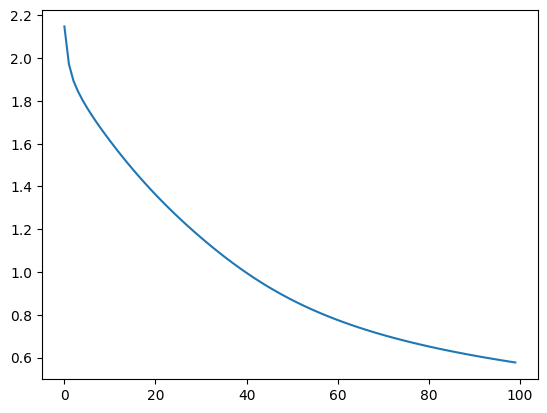

In [58]:
plt.plot(lt)

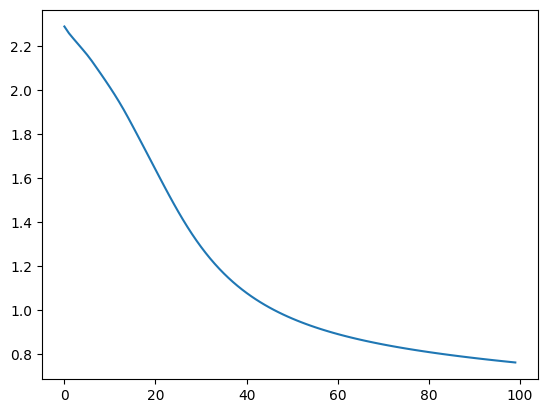

In [13]:
plt.plot(lt)

In [66]:
ce = CrossEntropy(optimize_exponents=True)

nn3_old = Network(reg_func=none_reg, loss_func=ce, reg_lambda=0.0, lr=0.01)

nn3_old.add_layer(Linear((784, 10), weight=init_weight1, bias=init_bias1))
nn3_old.add_layer(BatchNorm1d(10))
nn3_old.add_layer(LReLU(0.001))
nn3_old.add_layer(Linear((10, 10), weight=init_weight2, bias=init_bias2))

nn3_new = deepcopy(nn3_old)

In [67]:
loss_new = []
for ep in range(100):
    loss_ = []
    for i, batch in enumerate(get_batches(X_test_small, y_test_small, batch_size)):
        
        x_batch, y_batch = batch
        
        loss_.append(nn3_new.my_fit(x_batch, y_batch, False).item())
        
    loss_new.append(sum(loss_) / len(loss_))


loss_old = []
for ep in range(100):
    loss_ = []
    for i, batch in enumerate(get_batches(X_test_small, y_test_small, batch_size)):
        
        x_batch, y_batch = batch
        
        loss_.append(nn3_old.my_fit(x_batch, y_batch, True).item())
        
    loss_old.append(sum(loss_) / len(loss_))



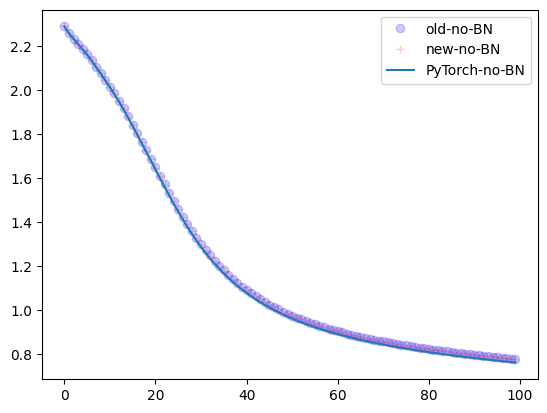

In [25]:
plt.plot(loss_old, 'bo', label='old-no-BN', alpha=.2)
plt.plot(loss_new, 'r+', label='new-no-BN', alpha=0.2)
plt.plot(lt, label='PyTorch-no-BN')
plt.legend()

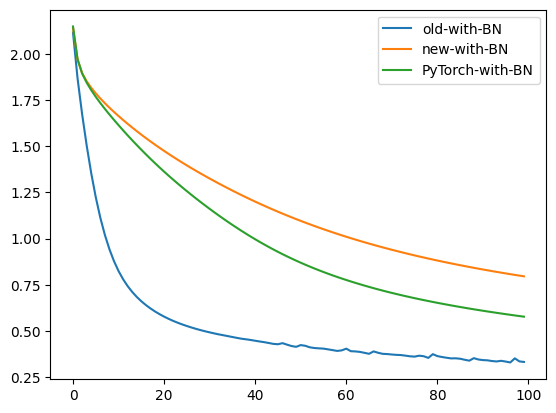

In [61]:
plt.plot(loss_old[:200], label='old-with-BN')
plt.plot(loss_new[:200], label='new-with-BN')
plt.plot(lt[:200], label='PyTorch-with-BN')
plt.legend()

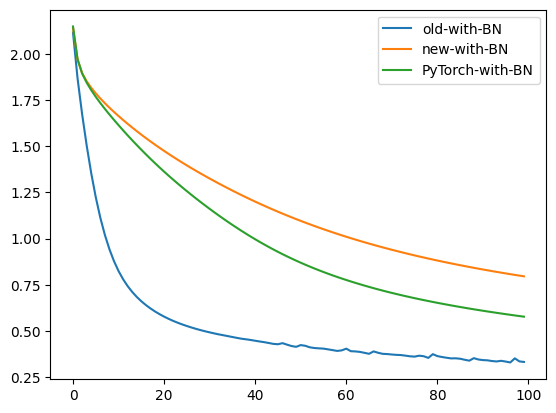

In [65]:
plt.plot(loss_old[:200], label='old-with-BN')
plt.plot(loss_new[:200], label='new-with-BN')
plt.plot(lt[:200], label='PyTorch-with-BN')
plt.legend()

In [668]:
def get_probabilities(x):
    _gamma = torch.amax(x)
    _exp_outputs = (x - _gamma).exp()
    return (_exp_outputs.T / _exp_outputs.sum(axis=1)).T

In [669]:
# dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

In [675]:
x = torch.randn((10, 10), requires_grad=True)

n = 10
mybn = BatchNorm1d(n)

In [720]:


xbn_my = mybn(x)

one_hot_target = torch.nn.functional.one_hot(torch.arange(10), 10)
dl_dbn = -(one_hot_target - get_probabilities(xbn_my)) / len(xbn_my)

mean_cross_entropy = -((xbn_my * one_hot_target).sum(axis=1, keepdim=True) - xbn_my.exp().sum(axis=1, keepdim=True).log()).mean()
my_x_grad = mybn.backward(dl_dbn)[0]

mean_cross_entropy.item()


2.981389284133911

In [573]:
mean_cross_entropy

tensor(2.9975, grad_fn=<NegBackward0>)

In [574]:
torch_ce = torch.nn.CrossEntropyLoss()
torch_bn = torch.nn.BatchNorm1d(10)

# torch_bn.weight = torch.nn.Parameter(my_bn.gamma.squeeze())
# torch_bn.bias = torch.nn.Parameter(my_bn.beta.squeeze())

xbn = torch_bn(x)
l = torch_ce(xbn, torch.arange(10))
l.backward()
l

tensor(2.9975, grad_fn=<NllLossBackward0>)

In [575]:
torch.allclose(x.grad, my_x_grad)

True

In [563]:
cBn.backward(dl_dbn)

(tensor([[-0.0592,  0.0114,  0.0069,  0.0068,  0.0278,  0.0020,  0.0119, -0.0022,
           0.0101,  0.0035],
         [ 0.0084, -0.0815,  0.0080,  0.0081,  0.0407,  0.0166,  0.0182, -0.0130,
           0.0153,  0.0100],
         [ 0.0074,  0.0094, -0.0788,  0.0378,  0.0256,  0.0068,  0.0213,  0.0071,
           0.0088,  0.0366],
         [ 0.0077,  0.0086,  0.0141, -0.0939,  0.0098,  0.0466,  0.0234,  0.0128,
           0.0167,  0.0169],
         [ 0.0086,  0.0101,  0.0075,  0.0071, -0.1169, -0.0006,  0.0049,  0.0263,
           0.0096,  0.0010],
         [ 0.0062,  0.0055,  0.0038,  0.0078, -0.0024, -0.0900, -0.0044,  0.0123,
           0.0043, -0.0013],
         [ 0.0024,  0.0057,  0.0067,  0.0035,  0.0036,  0.0209, -0.1079,  0.0071,
           0.0045, -0.0066],
         [ 0.0067,  0.0173,  0.0129,  0.0044,  0.0066, -0.0046,  0.0160, -0.0593,
           0.0231,  0.0114],
         [ 0.0072,  0.0053,  0.0105,  0.0116, -0.0022, -0.0251,  0.0122, -0.0037,
          -0.1003,  0.0022],
 

In [562]:
x.grad

tensor([[-0.0592,  0.0114,  0.0069,  0.0068,  0.0278,  0.0020,  0.0119, -0.0022,
          0.0101,  0.0035],
        [ 0.0084, -0.0815,  0.0080,  0.0081,  0.0407,  0.0166,  0.0182, -0.0130,
          0.0153,  0.0100],
        [ 0.0074,  0.0094, -0.0788,  0.0378,  0.0256,  0.0068,  0.0213,  0.0071,
          0.0088,  0.0366],
        [ 0.0077,  0.0086,  0.0141, -0.0939,  0.0098,  0.0466,  0.0234,  0.0128,
          0.0167,  0.0169],
        [ 0.0086,  0.0101,  0.0075,  0.0071, -0.1169, -0.0006,  0.0049,  0.0263,
          0.0096,  0.0010],
        [ 0.0062,  0.0055,  0.0038,  0.0078, -0.0024, -0.0900, -0.0044,  0.0123,
          0.0043, -0.0013],
        [ 0.0024,  0.0057,  0.0067,  0.0035,  0.0036,  0.0209, -0.1079,  0.0071,
          0.0045, -0.0066],
        [ 0.0067,  0.0173,  0.0129,  0.0044,  0.0066, -0.0046,  0.0160, -0.0593,
          0.0231,  0.0114],
        [ 0.0072,  0.0053,  0.0105,  0.0116, -0.0022, -0.0251,  0.0122, -0.0037,
         -0.1003,  0.0022],
        [ 0.0046,  

In [484]:
import torch

torch_bn = torch.nn.BatchNorm1d(10)
torch_ce = torch.nn.CrossEntropyLoss()

torch_bn.weight = torch.nn.Parameter(my_bn.gamma.squeeze())
torch_bn.bias = torch.nn.Parameter(my_bn.beta.squeeze())

# Forward pass
xbn = torch_bn(x)

# Retain gradient for xbn
xbn.retain_grad()

# Compute loss
l = torch_ce(xbn, torch.arange(10))

# Backward pass
l.backward()

# Access the gradient of xbn
print(xbn.grad)  # This will give you dl/d(xbn)

tensor([[-0.0980,  0.0062,  0.0155,  0.0023,  0.0055,  0.0455,  0.0167,  0.0020,
          0.0015,  0.0028],
        [ 0.0071, -0.0893,  0.0028,  0.0638,  0.0040,  0.0020,  0.0025,  0.0017,
          0.0045,  0.0009],
        [ 0.0020,  0.0060, -0.0890,  0.0034,  0.0019,  0.0051,  0.0072,  0.0287,
          0.0008,  0.0341],
        [ 0.0085,  0.0042,  0.0012, -0.0852,  0.0064,  0.0445,  0.0028,  0.0046,
          0.0044,  0.0086],
        [ 0.0184,  0.0033,  0.0019,  0.0076, -0.0856,  0.0027,  0.0043,  0.0103,
          0.0306,  0.0066],
        [ 0.0172,  0.0036,  0.0029,  0.0020,  0.0082, -0.0979,  0.0365,  0.0071,
          0.0161,  0.0044],
        [ 0.0159,  0.0040,  0.0103,  0.0090,  0.0027,  0.0020, -0.0975,  0.0309,
          0.0183,  0.0044],
        [ 0.0026,  0.0115,  0.0266,  0.0019,  0.0250,  0.0084,  0.0079, -0.0948,
          0.0046,  0.0064],
        [ 0.0025,  0.0354,  0.0076,  0.0060,  0.0101,  0.0085,  0.0046,  0.0031,
         -0.0906,  0.0129],
        [ 0.0120,  

In [485]:
torch.abs(xbn.grad - dl_dbn).max()

tensor(1.1176e-08, grad_fn=<MaxBackward1>)

In [486]:
torch.abs(xbn_my - xbn).max()

tensor(2.3842e-07, grad_fn=<MaxBackward1>)

In [518]:
x = torch.rand((10, 10))

xmean = x.mean(0, keepdim=True)
xvar = (x.var(0, keepdim=True, unbiased=False) + 1e-5)

xvar_inv = torch.sqrt(xvar)**-1
xraw = (x - xmean) * xvar_inv
xraw

tensor([[ 9.4172e-01,  4.1672e-02,  2.5657e-01, -1.6293e+00,  1.8485e+00,
          1.0613e+00,  7.8434e-01, -8.9071e-01,  1.2013e+00,  8.8416e-01],
        [ 2.4092e-01, -1.0990e+00,  1.5264e+00,  1.0040e+00, -3.9175e-01,
          1.0957e+00,  1.1343e+00, -1.2813e+00,  2.3199e-01,  7.9816e-01],
        [-7.8347e-01, -1.0853e+00, -1.5076e+00,  6.0687e-01, -8.5463e-01,
          8.5280e-01, -1.4043e+00, -9.3556e-02, -1.3239e+00,  4.8695e-01],
        [-1.7819e+00, -4.8601e-01, -8.7661e-01, -1.3369e+00, -1.5269e+00,
          3.0918e-01,  1.1510e+00,  1.4270e+00,  5.9426e-02,  7.8396e-02],
        [-1.2704e+00, -1.0569e+00, -1.4091e-01,  9.1541e-01,  9.4450e-02,
         -2.3383e-01, -1.3598e+00, -8.6818e-01,  1.5114e+00,  1.2520e+00],
        [-3.4711e-01, -5.1965e-01,  1.1780e+00, -1.5754e-01,  4.7851e-01,
         -4.7296e-01,  9.6013e-01,  7.1813e-01, -9.7158e-01,  7.5134e-02],
        [ 2.3494e-01,  1.5419e+00, -1.2056e+00,  8.4806e-01, -9.0551e-01,
          8.6900e-02,  4.9380e-0

In [523]:
torch_bn = torch.nn.BatchNorm1d(10)
torch.allclose(torch_bn(x), xraw)

True

In [554]:
import numpy as np

class CustomBatchNorm:
    def __init__(self, num_features, epsilon=1e-5):
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.epsilon = epsilon

    def forward(self, x):
        self.x = x
        self.mean = torch.mean(x, keepdim=True, axis=0)
        self.variance = torch.var(x, keepdim=True, unbiased=False, axis=0)
        self.x_hat = (x - self.mean) / torch.sqrt(self.variance + self.epsilon)
        self.y = self.gamma * self.x_hat + self.beta
        return self.y

    def backward(self, dL_dy):
        N = self.x.shape[0]

        # Gradients for gamma and beta
        dL_dgamma = torch.sum(dL_dy * self.x_hat, axis=0)
        dL_dbeta = torch.sum(dL_dy, axis=0)

        # Gradient with respect to normalized input
        dL_dx_hat = dL_dy * self.gamma

        # Gradient with respect to variance
        dL_dvariance = torch.sum(dL_dx_hat * (self.x - self.mean) * -0.5 * (self.variance + self.epsilon) ** -1.5, axis=0)

        # Gradient with respect to mean
        dL_dmean = torch.sum(dL_dx_hat * -1 / torch.sqrt(self.variance + self.epsilon), axis=0) + dL_dvariance * torch.mean(-2 * (self.x - self.mean), axis=0)

        # Gradient with respect to input
        dL_dx = (dL_dx_hat / torch.sqrt(self.variance + self.epsilon)) + (dL_dvariance * 2 / N * (self.x - self.mean)) + (dL_dmean / N)

        return dL_dx, dL_dgamma, dL_dbeta

In [566]:
x = torch.rand((10, 10))

xmean = x.mean(0, keepdim=True)
xvar = (x.var(0, keepdim=True, unbiased=False) + 1e-5)

xvar_inv = torch.sqrt(xvar)**-1
xraw = (x - xmean) * xvar_inv
xraw

tensor([[-1.1403,  1.1735, -0.7960, -0.9548, -0.3952, -1.7733,  0.7488,  1.0071,
          0.5092,  0.9171],
        [-0.4406, -0.3438, -0.5674,  0.5859,  0.8212,  1.4567, -0.6795, -1.6269,
          0.3389,  0.3739],
        [ 0.8357, -0.7179, -0.3264, -1.2101,  0.8511,  0.2123,  1.3907,  0.9287,
          1.6295, -1.1501],
        [-0.3013,  0.1555,  1.2074,  0.3971,  0.7191, -0.2430,  0.4121, -1.0971,
         -0.2959,  0.7303],
        [-0.8481, -0.9845, -1.3700, -1.2030, -1.5253, -0.0092, -0.4643,  0.6417,
         -0.7884,  0.4832],
        [ 1.6478,  1.6217, -1.4366,  0.9251, -1.5409,  1.0585,  0.4555, -0.0080,
         -1.1716,  0.8023],
        [-0.8681,  1.0979,  1.0581,  1.3856,  0.8354, -1.2223,  1.2613,  0.7587,
         -1.9071,  0.7197],
        [-0.1958, -1.7122,  1.2018,  1.3078,  0.4679,  0.4213, -0.0119,  0.1770,
          0.9211, -1.6159],
        [ 1.8020,  0.1589,  0.0435, -1.0791, -1.1849, -0.9073, -1.6404,  0.8236,
          0.1522, -1.7169],
        [-0.4914, -

In [568]:
cBn = CustomBatchNorm(10)
torch.allclose(cBn.forward(x), xraw)

True